In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt

In [25]:
# Устройство (CPU или GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [26]:
# Генерация данных с кружочками и масками
class BaseDataProvider(object):
    channels = 1
    n_class = 2

    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        data, label = self._next_data()
        train_data = self._process_data(data)
        labels = self._process_labels(label)
        train_data, labels = self._post_process(train_data, labels)
        nx, ny = train_data.shape[1], train_data.shape[0]
        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class)

    def _process_labels(self, label):
        if self.n_class == 2:
            nx, ny = label.shape[1], label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)
            label = label.astype(np.bool_)
            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels
        return label

    def _process_data(self, data):
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)
        if np.amax(data) != 0:
            data /= np.amax(data)
        return data

    def _post_process(self, data, labels):
        return data, labels

    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx, ny = train_data.shape[1], train_data.shape[2]
        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))
        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels
        return X, Y

class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs

    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)

In [27]:
def create_image_and_label(nx, ny, cnt=10, r_min=5, r_max=50, border=16, sigma=20):
    image = np.ones((nx, ny, 1))
    label = np.zeros((nx, ny), dtype=np.bool_)
    mask = np.zeros((nx, ny), dtype=np.bool_)
    for _ in range(cnt):
        a, b = np.random.randint(border, nx-border), np.random.randint(border, ny-border)
        r = np.random.randint(r_min, r_max)
        y, x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r
        mask = np.logical_or(mask, m)
        image[m] = np.random.randint(1, 255)
    label[mask] = 1
    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)
    return image, label

In [28]:
# класс для создания датасета с кружочками и их масками
class CircleDataset(Dataset):
    def __init__(self, nx, ny, cnt=20):
        # Создаем генератор данных с кружочками
        self.generator = GrayScaleDataProvider(nx, ny, cnt=cnt, r_min=3, r_max=15)

    def __len__(self):
        # Длина датасета (1000 изображений)
        return 1000

    def __getitem__(self, idx):
        # Получаем одно изображение и его маску
        x_data, y_data = self.generator(1)
        # Преобразуем изображение и маску в тензоры
        image = torch.from_numpy(x_data[0]).float()
        mask = torch.from_numpy(y_data[0, ..., 1]).long()
        # Возвращаем изображение с перестановкой осей и маску
        return image.permute(2, 0, 1), mask

# Определение UNet модели с корректировкой
def conv3x3(in_channels, out_channels, stride=1, padding=1):
    # Определяем сверточный слой 3x3 с заданными каналами и параметрами
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=padding)

def upconv2x2(in_channels, out_channels):
    # Определяем транспонированную свертку 2x2 для увеличения размерности
    return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

# DownConv и UpConv: Эти классы описывают один уровень энкодера и декодера соответственно.
# DownConv уменьшает размер изображения с помощью сверток и пулинга,
# а UpConv увеличивает размер изображения с помощью транспонированной свертки и конкатенации с промежуточными выходами из энкодера.

# Свертка
class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels, pooling=True):
        super(DownConv, self).__init__()
        self.pooling = pooling
        # Два последовательных сверточных слоя
        self.conv1 = conv3x3(in_channels, out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        # Пулинг-слой для уменьшения размерности
        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Последовательное применение сверточных слоев с ReLU
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        before_pool = x
        # Если pooling=True, то применяем MaxPool2D
        if self.pooling:
            x = self.pool(x)
        return x, before_pool # Возвращаем выход и промежуточное значение для skip connections

# Развертка
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        # Транспонированная свертка для увеличения размерности
        self.upconv = upconv2x2(in_channels, out_channels)
        # Два последовательных сверточных слоя для объединенного тензора
        self.conv1 = conv3x3(out_channels * 2, out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)

    def forward(self, from_down, from_up):
        # Увеличиваем from_up и объединяем его с from_down
        from_up = self.upconv(from_up)
        x = torch.cat((from_up, from_down), 1) # Конкатенация по каналам
        # Применяем сверточные слои с ReLU
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x

class UNet(nn.Module):
    def __init__(self, num_classes, in_channels=1, depth=4, start_filts=8):
        super(UNet, self).__init__()
        self.down_convs = nn.ModuleList()
        self.up_convs = nn.ModuleList()

        # Задаем число фильтров на каждом уровне
        filters = [start_filts * (2 ** i) for i in range(depth)]

        # Создаем энкодер (DownConv) с уменьшением размерности
        for i in range(depth):
            pooling = True if i < depth - 1 else False
            in_ch = in_channels if i == 0 else filters[i-1]
            out_ch = filters[i]
            self.down_convs.append(DownConv(in_ch, out_ch, pooling))

        # Создаем декодер (UpConv) с увеличением размерности
        for i in range(depth - 1):
            in_ch = filters[depth - i - 1]
            out_ch = filters[depth - i - 2]
            self.up_convs.append(UpConv(in_ch, out_ch))

        # Финальный сверточный слой для получения маски с num_classes каналами
        self.conv_final = nn.Conv2d(filters[0], num_classes, kernel_size=1)

    def forward(self, x):
        encoder_outs = []
        # Энкодер: сохраняем промежуточные выходы для skip connections
        for down in self.down_convs:
            x, before_pool = down(x)
            encoder_outs.append(before_pool)
        # Переворачиваем выходы энкодера для декодера
        encoder_outs = encoder_outs[::-1]  # обратный порядок

        # Декодер: соединяем увеличенные выходы с сохраненными
        for i, up in enumerate(self.up_convs):
            x = up(encoder_outs[i+1], x)

        # Финальный слой для предсказания маски
        x = self.conv_final(x)
        return x

In [ ]:
nx, ny = 128, 128 # 128 na 128 izobrazhenije

# Создаем экземпляр датасета CircleDataset с 10 кружочками на каждом изображении
train_dataset = CircleDataset(nx, ny, cnt=10)

# Используем DataLoader для загрузки данных в батчах по 8 изображений и перемешиваем их
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Создаем модель UNet с 2 выходными классами (фон и кружочки)
# Один канал на входе (черно-белое изображение), глубина сети — 4 уровня, начальное количество фильтров — 8
model = UNet(num_classes=2, in_channels=1, depth=4, start_filts=8).to(device)

# Определяем оптимизатор Adam для обновления параметров модели
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Определяем функцию потерь — используем CrossEntropyLoss, поскольку задача — сегментация на два класса
criterion = nn.CrossEntropyLoss()

In [ ]:
epochs = 3
for epoch in range(epochs):
    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        # Прогоняем изображения через модель, чтобы получить предсказания
        output = model(images)
        loss = criterion(output, masks)
        loss.backward()
        optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/3], Loss: 0.6472
Epoch [1/3], Loss: 0.6451
Epoch [1/3], Loss: 0.6422
Epoch [1/3], Loss: 0.6458
Epoch [1/3], Loss: 0.6377
Epoch [1/3], Loss: 0.6380
Epoch [1/3], Loss: 0.6365
Epoch [1/3], Loss: 0.6336
Epoch [1/3], Loss: 0.6314
Epoch [1/3], Loss: 0.6344
Epoch [1/3], Loss: 0.6336
Epoch [1/3], Loss: 0.6287
Epoch [1/3], Loss: 0.6292
Epoch [1/3], Loss: 0.6277
Epoch [1/3], Loss: 0.6228
Epoch [1/3], Loss: 0.6176
Epoch [1/3], Loss: 0.6159
Epoch [1/3], Loss: 0.6083
Epoch [1/3], Loss: 0.5946
Epoch [1/3], Loss: 0.5866
Epoch [1/3], Loss: 0.5708
Epoch [1/3], Loss: 0.5353
Epoch [1/3], Loss: 0.4971
Epoch [1/3], Loss: 0.4542
Epoch [1/3], Loss: 0.5661
Epoch [1/3], Loss: 0.4900
Epoch [1/3], Loss: 0.4446
Epoch [1/3], Loss: 0.4438
Epoch [1/3], Loss: 0.4622
Epoch [1/3], Loss: 0.4877
Epoch [1/3], Loss: 0.4534
Epoch [1/3], Loss: 0.4653
Epoch [1/3], Loss: 0.4826
Epoch [1/3], Loss: 0.4516
Epoch [1/3], Loss: 0.4364
Epoch [1/3], Loss: 0.4676
Epoch [1/3], Loss: 0.4471
Epoch [1/3], Loss: 0.4371
Epoch [1/3],

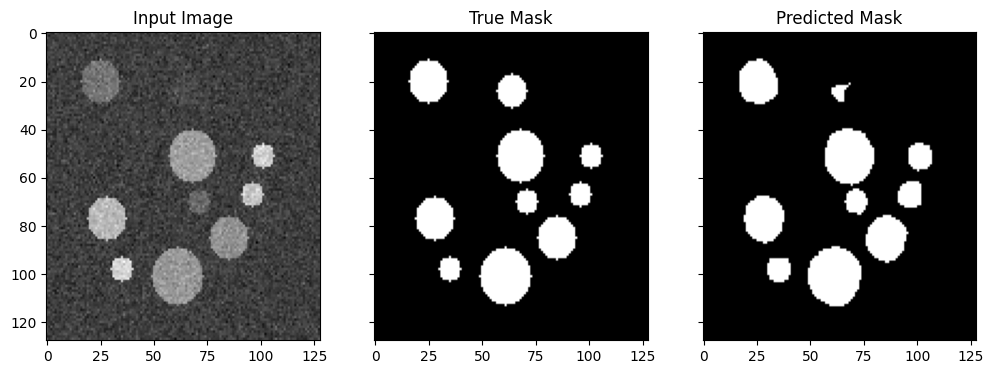

In [31]:
import matplotlib.pyplot as plt

def visualize_predictions(generator, model, device, nx=128, ny=128):
    # Генерация одного тестового изображения
    x_test, y_test = generator(1)
    image = torch.from_numpy(x_test[0]).float().permute(2, 0, 1).unsqueeze(0).to(device)
    true_mask = y_test[0, ..., 1]

    # Получение предсказаний от модели
    model.eval()
    with torch.no_grad():
        output = model(image)
        pred_mask = torch.argmax(output[0], dim=0).cpu().numpy()

    # Построение графиков
    fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
    ax[0].imshow(x_test[0, ..., 0], aspect="auto", cmap="gray")
    ax[0].set_title("Input Image")
    ax[1].imshow(true_mask, aspect="auto", cmap="gray")
    ax[1].set_title("True Mask")
    ax[2].imshow(pred_mask, aspect="auto", cmap="gray")
    ax[2].set_title("Predicted Mask")
    plt.show()

# Пример использования функции визуализации
nx, ny = 128, 128
generator = GrayScaleDataProvider(nx, ny, cnt=10, r_min=3, r_max=15)
visualize_predictions(generator, model, device, nx, ny)
